# AUDL Predictive Model Write-Up

## Introduction


>The American Ultimate Disc League (or AUDL) is the official professional ultimate league in the world. Founded in 2012 with a mission to increase the “visibility of one of North America’s fastest growing sports by creating fun, family friendly events that showcase the sport being played at its highest level.” (https://theaudl.com/league/about) While the rules of the AUDL vary slightly from the more popular and established club ultimate Triple Crown Tour run by USA Ultimate, the basic structure of the game remains. To read more about to rules of the AUDL, feel free to consult this page: https://theaudl.com/league/ultimate101. My primary interest in the AUDL lies in the fact that for every game since the league’s creation, team statistics have been recorded and published. While these team statistics offer ultimate news sites and fans a glimpse into how any team is performing comparatively, little is put forth on predictions on games – as opposed to the NBA, which (albeit has a much firmer footing in the sports entertainment world) has many predictive models and algorithms to predict the outcome of upcoming games. This post serves to walkthrough my process in building one of the first machine learning predictive algorithms in the AUDL. 

## The Data

>After using BeautifulSoup to get the stats tables on the AUDL’s website (https://theaudl.com/league/stats), I combined all game outcomes into one data frame. Calling this data frame all_scores – it holds the home team, away team, each team’s respective score and the location of the game. Then I repeated a similar process for the team stats of each team. For every year since 2012, I parsed each season’s team stats table into its own data frame, then concatenated each of these tables into one large data frame called “full team stats” (or FTS). The team name plus the last two digits of the season year acted as the index for this data frame, thus “New York Empire19” represented the New York Empire for just the 2019 season, as to make teams unique to their respective seasons. I repeated this process for the all_scores data frame as well. Examples of the head of full team stats data frame follow: 

   <img src="statline.png">
	
    
>Additionally, here's a table which outlines exactly what each statistic is measuring: 

   <img src="statdef.png" width=230px; height=300px;>
   
>I split the data I had scraped into two additional data frames for this project. The first was every recorded game with the home and away team’s metrics, I prefaced each metric with either H (for home) or A (for away). I also added the margin between the final score (home team’s points – away team’s points). I labeled this data frame asdf – short for all stats data frame. I made the last dataframe similar to asdf, but only with the per game statistics, excluding running season total metrics such as total points or completions. The reasoning behind this being narrowing down 38 input features down to just 18 to give the per game statistics more weight to produce more accurate results. I refer to this data frame as pgdf (per game data frame). After some minor data cleaning and sorting our data into these respective manners, let’s dive into some exploratory data analysis.  


>For simplicity's sake, I've already saved these files in a seperate csv and will read them in. 

In [5]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#read in dataframes
pgdf = pd.read_csv('FULL_DATAFRAME')
#only stats per game, doesn't include season running total metrics, 
#indicies are individual games in all AUDL history
#margin = hometeam points - away team points

asdf = pd.read_csv('all_stats_df')
#All games in audl history, includes full metrics and margin 

fts = pd.read_csv('FULL_TEAM_STATS')
#Only season total metrics, index are teams 

In [7]:
#clean data a hair from csv file
pgdf.drop('Unnamed: 0',axis=1,inplace=True)
fts.set_index('Team',inplace=True)
asdf.drop('Unnamed: 0',axis=1,inplace=True)
asdf.rename({'0':'margin'},axis=1,inplace=True)

## Exploratory Analysis


>I started by running a correlation with the margin column to see which features had the highest effect on the score (or margin column in our case). Below you’ll see the code and results


In [8]:
asdf.corrwith(asdf['margin']).sort_values(ascending=False).drop('margin')

A_L       0.591798
H_PM      0.508185
H_W       0.508103
A_PAPG    0.500742
H_PMPG    0.489076
H_PTS     0.468638
H_DEFF    0.463084
H_PPG     0.460333
H_OEFF    0.449924
H_BLK     0.363353
A_TPG     0.360103
H_BPG     0.313952
H_G       0.305157
A_PA      0.280492
H_CMPR    0.248988
A_TO      0.199924
H_CMP     0.198454
H_T       0.044570
H_CPG     0.031199
A_T       0.013460
A_CPG    -0.039400
H_TO     -0.134257
A_CMP    -0.198824
H_PA     -0.216113
A_G      -0.292493
H_TPG    -0.295343
A_CMPR   -0.300092
A_BPG    -0.301335
A_BLK    -0.353360
H_PAPG   -0.437161
A_DEFF   -0.493279
A_PTS    -0.498203
H_L      -0.507196
A_PPG    -0.507453
A_OEFF   -0.523108
A_PMPG   -0.547617
A_PM     -0.557555
A_W      -0.576193
dtype: float64

>As you can see, Away Losses and Away Wins had the highest correlation in predicting the margin, while Plus Minus for both the home team and away team proved to be the next most significant features in predicting the margin. In fact, many features had a notable impact in predicting the margin, I put each feature’s correlation value in a data frame, with each row representing the most impactful features both positively and negatively.



In [56]:
cmatrix = asdf.corrwith(asdf['margin']).sort_values(ascending=False).drop('margin')
cmpos = cmatrix.where(cmatrix>0).dropna()
cmneg = cmatrix.where(cmatrix<0).dropna()
pos = cmpos.to_frame().reset_index()
neg = cmneg.to_frame().reset_index().sort_values(by=[0],axis=0)
neg.reset_index().drop('level_0',axis=1,inplace=True)
neg = neg.reset_index().drop('level_0',axis=1)
corrdf = pd.concat([pos,neg],axis=1)
corrdf.rename({0:"Corr Value","index":"Metric"},axis=1,inplace=True)
corrdf

,Metric,Corr Value,Metric,Corr Value
0,A_L,0.591798,A_W,-0.576193
1,H_PM,0.508185,A_PM,-0.557555
2,H_W,0.508103,A_PMPG,-0.547617
3,A_PAPG,0.500742,A_OEFF,-0.523108
4,H_PMPG,0.489076,A_PPG,-0.507453
5,H_PTS,0.468638,H_L,-0.507196
6,H_DEFF,0.463084,A_PTS,-0.498203
7,H_PPG,0.460333,A_DEFF,-0.493279
8,H_OEFF,0.449924,H_PAPG,-0.437161
9,H_BLK,0.363353,A_BLK,-0.353360


>Overall the takeaway from these correlations is that plus minus (cumulative for the season, not per game), proves to be an impactful metric in determining the score. Additionally, the two top metrics are both concerned with the away team (losses and wins respectively), while the home team wins/ losses, are roughly 15% less impactful than their away metric counterpart. What this tells us is that, and what is true for most sports, is that home field advantage matters. 

>Repeating a similar correlation process with the per game data frame (pgdf) produces similar results as shown below: 


In [57]:
pgdf.corrwith(pgdf['margin']).sort_values(ascending=False).drop('margin')

A_PAPG    0.500742
H_PMPG    0.489076
H_DEFF    0.463084
H_PPG     0.460333
H_OEFF    0.449924
A_TPG     0.360103
H_BPG     0.313952
H_CMPR    0.248988
H_CPG     0.031199
A_CPG    -0.039400
H_TPG    -0.295343
A_CMPR   -0.300092
A_BPG    -0.301335
H_PAPG   -0.437161
A_DEFF   -0.493279
A_PPG    -0.507453
A_OEFF   -0.523108
A_PMPG   -0.547617
dtype: float64

>Plus minus per game (PMPG) still shows to be impactful, however the difference here is that points against per game (PAPG) proves to be significant input feature as well. Additionally, the offensive efficiency is shown to have a notable impact as well. But again, as we saw with the previous correlation data frame, the away team’s offensive efficiency, plus minus per game and points against per game impact the margin of the score significantly more than the corresponding metric for the home team – again this analysis shows home field advantage matters. 
	Other things to note – metrics which measured completions didn’t have too much of an effect on the outcome of the score. While most other metrics in the pgdf, had somewhat of an impact on score ranging from .3 - .5 correlation value. 



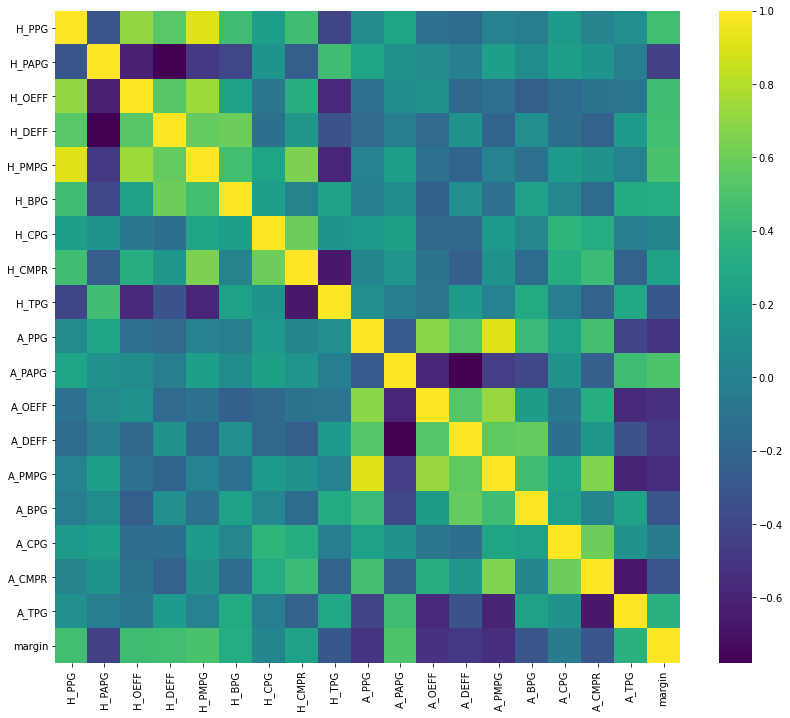

In [60]:
plt.figure(figsize=(14,12))
sns.heatmap(pgdf.corr(),cmap="viridis")

## The Models

>Now that we had taken a glance at the data, let’s jump into constructing a model. I used the sci-kit learn python library to build my models, to view the full code, check out my github page (https://github.com/Alex-E-Walsh). 

>My initial thoughts were to use the asdf to train a linear regression model to predict the margin of the score (home team score – away team score). A positive margin score indicating a home team win.
>I started with a preliminary multivariate linear regression using all the team statistics as features. Using 70% of the data to train the algorithm, of the 30% testing data (or 337 games), the linear regression algorithm was able to correctly predict the winner 79.42% from the testing data. That is from the 337 games of the training set, only 66 games were incorrectly predicted on which team won. As far the score spread for the linear regression, I offer some metrics below: 

Mean Absolute Error:  3.548 
<br>
Mean Squared Error: 20.428
<br>
Root Mean Squared Error: 4.520


<img src="dist1.png" width=400px; >
<img src="regline1.png" width=400px;>

>The above plots represent the disparity between the actual vs predicted score spread. The scatter plot shows how the model attempted to predict the test data, with each point being an individual game and the red line showing where the model would expect the margin to be located. All points along the red line would represent 100% prediction accuracy, but some variance is always expected as with any sport, so this serves as a nice baseline. Building a linear regression model with the pgdf yields similar results with no significant changes in performance metrics to be notable, so let’s move on to try and implement an artificial neural network to see if we’re able to improve upon performance metrics. 


>Below is the code I used to build the neural net for the linear regression model, a Sequential model with dense layers, relu activation, adagrad optimizer with early stopping as well. Like the original model, our loss function is MSE. 

In [ ]:
mdl = Sequential()
mdl.add(Dense(39,activation='relu'))
mdl.add(Dense(21,activation='relu'))
mdl.add(Dense(11,activation='relu'))
mdl.add(Dense(6,activation='relu'))
mdl.add(Dense(1))
mdl.compile(optimizer = 'adagrad' , loss='mse')

early_stop = EarlyStopping(monitor = 'val_loss', mode='min',verbose=1,patience=25)

mdl.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          epochs=800,
          callbacks = [early_stop])

>After evaluating our model on our test data, we end up with a loss function of 19.861 – slightly better than our original linear regression model! 

   <img src="lossout.png" >
   
>Below are the same iteration of graphs for our original linear regression model

<img src="dist2.png" width=400px; >
<img src="regline2.png" width=400px;>

>Let’s next move away from regressions and onto classification, here we will attempt to simply predict which team will win a game, and not the margin of the score. 


## Neural Net Classifier 

>For the implementation of a neural net, we used the same data frame as the multivariate regression: asdf, that being a combination of team stats with the scores data frame. Essentially, for every game played, we fetch the team stats for both home and away team and the margin of the points (home team points - away team points) is the target value we are attempting to predict. Thus, our total features add up to 38 (19 unique statistics per team). I used a Sequential model with Dense layers, and a relu activation function, I also included dropout layers and early stopping callbacks to limit epochs. As far as training, our early stopping function stopped training after 64 epochs with a final MSE of 20.724 – slightly worse performance than our linear regression model!

In [ ]:
regm = Sequential() 
regm.add(Dense(39,activation='relu'))
regm.add(Dropout(0.2))
regm.add(Dense(24,activation='relu'))
regm.add(Dropout(0.2))
regm.add(Dense(1, activation='sigmoid'))
regm.compile(optimizer = 'adam' , loss='binary_crossentropy')

regm.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks=[early_stop]
          )

<img src="confmax.png" width=400px;>

>When it comes to predict the outcomes of each games, from our test set, our neural net was able to predict the winner of 80.71% percent of the time. Negligibly better than our simple linear regression model. To improve this number, let’s move on to another model

## RFE Model

>Starting with a logistic regression model, I used recursive feature elimination (or RFE) to knock off half of my features and see if this will increase performance. Essentially what RFE does is remove the weaker features (those with the lowest coef_) recursively until we reach the desired number of features specified. In my case I narrowed down my features from 38 down to 24 features, I ran a logistic regression model initially similar to the one above with the RFE features to see performance increased. 


>This gave slightly better performance with accuracy around 82%, not a significant improvement for the small dataset we are working with, but noteable. 

<img src="confmax2.png" width=450px;>

>While through many models, I have been only marginally successful in increasing accuracy of our games, maybe that is because there are some features that cannot be assigned numbers. As is the case with most predictive algorithms in sports, there is a still an element of randomness that makes it worthy entertainment. Largely I would consider this project to be a success, a highest model of 82% accuracy in predicting outcomes is fairly decent in the world of sports predictions.

>Feel free to check out this site where I you can run each of these models 